# Encryptable attributes
As the codebase increases in complexity, we encounter cases in which new objects can contain multiple tensors (eg a layer can have weights, filters, bias).
In such cases one would have to expose encrypt and decrypt functionality for all layers.
This becomes a lot of boilerplate code to accomplish something which is really simple.
To avoid this, we provide an "Encryptable" mixin which enables to do the same by simply extending it.
Being a form of inheritance, its behaviour can still be customised via overloading.

In [1]:
from syft.encryptable import Encryptable
from syft.he.paillier import KeyPair, PaillierTensor
from syft import TensorBase
import numpy as np

## Simple use case
In this case we have a FinalTest case containing a TensorBase, and some other classes with various levels of nesting.
All we have to do is specify in the "encryptables" field the names of the objects we wish to automagically encrypt!

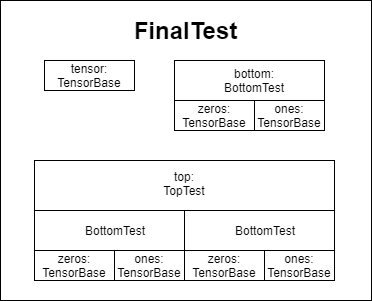

In [2]:
class BottomTest(Encryptable):
    encryptables = ['ones', 'zeros']
    def __init__(self):
        self.ones = TensorBase(np.ones(5))
        self.zeros = TensorBase(np.zeros(5))
    
    def __repr__(self):
        return "Ones: " + str(self.ones) + "\tZeros: " + str(self.zeros)


class TopTest(Encryptable):
    encryptables = ['left', 'right']
    def __init__(self):
        self.left = BottomTest()
        self.right = BottomTest()
    
    def __repr__(self):
        return "\tLeft: " + str(self.left) + "\n\tRight: " + str(self.right)
    
class FinalTest(Encryptable):
    encryptables = ['tensor', 'top', 'bottom', 'tensList']
    def __init__(self):
        self.tensList = []
        for i in range(1,100):
            self.tensList.append(TensorBase(np.ones((2,2))))
        self.tensor = TensorBase(np.asarray([13.1,6.1,45.1,2.1]))
        self.top = TopTest()
        self.bottom = BottomTest()
        
    def __repr__(self):
        return "Tensor: " + str(self.tensor) + "\nTop: " + str(self.top) + "\nBottom: " + str(self.bottom)


In [3]:
a = FinalTest()
b = FinalTest()

### Unencrypted a

In [4]:
a

Tensor: BaseTensor: [ 13.1   6.1  45.1   2.1]
Top: 	Left: Ones: BaseTensor: [ 1.  1.  1.  1.  1.]	Zeros: BaseTensor: [ 0.  0.  0.  0.  0.]
	Right: Ones: BaseTensor: [ 1.  1.  1.  1.  1.]	Zeros: BaseTensor: [ 0.  0.  0.  0.  0.]
Bottom: Ones: BaseTensor: [ 1.  1.  1.  1.  1.]	Zeros: BaseTensor: [ 0.  0.  0.  0.  0.]

In [5]:
a.tensList

[BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1., 

In [6]:
FinalTest.encryptables

['tensor', 'top', 'bottom', 'tensList']

Let's encrypt!

In [7]:
pubkey,prikey = KeyPair().generate()

In [8]:
a = a.encrypt(pubkey)
b = b.encrypt(pubkey)

In [9]:
a

Tensor: PaillierTensor: [e e e e]
Top: 	Left: Ones: PaillierTensor: [e e e e e]	Zeros: PaillierTensor: [e e e e e]
	Right: Ones: PaillierTensor: [e e e e e]	Zeros: PaillierTensor: [e e e e e]
Bottom: Ones: PaillierTensor: [e e e e e]	Zeros: PaillierTensor: [e e e e e]

In [10]:
a.tensList

[PaillierTensor: array([[e, e],
        [e, e]], dtype=object), PaillierTensor: array([[e, e],
        [e, e]], dtype=object), PaillierTensor: array([[e, e],
        [e, e]], dtype=object), PaillierTensor: array([[e, e],
        [e, e]], dtype=object), PaillierTensor: array([[e, e],
        [e, e]], dtype=object), PaillierTensor: array([[e, e],
        [e, e]], dtype=object), PaillierTensor: array([[e, e],
        [e, e]], dtype=object), PaillierTensor: array([[e, e],
        [e, e]], dtype=object), PaillierTensor: array([[e, e],
        [e, e]], dtype=object), PaillierTensor: array([[e, e],
        [e, e]], dtype=object), PaillierTensor: array([[e, e],
        [e, e]], dtype=object), PaillierTensor: array([[e, e],
        [e, e]], dtype=object), PaillierTensor: array([[e, e],
        [e, e]], dtype=object), PaillierTensor: array([[e, e],
        [e, e]], dtype=object), PaillierTensor: array([[e, e],
        [e, e]], dtype=object), PaillierTensor: array([[e, e],
        [e, e]], dtype=

Let's do encrypted operations!

In [11]:
c = a.tensor + b.tensor

In [12]:
a = a.decrypt(prikey)
b = b.decrypt(prikey)

In [13]:
c

PaillierTensor: array([e, e, e, e], dtype=object)

In [14]:
c.decrypt(prikey)

BaseTensor: array([ 26.2,  12.2,  90.2,   4.2])

In [15]:
a.tensList

[BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1.,  1.]]), BaseTensor: array([[ 1.,  1.],
        [ 1., 

## Real use case: polynomials
Polynomial functions will be used in many places for OpenMined and they need to operate both on encrypted (as activations) and unencrypted (for MPC) data.

In [16]:
from syft.nonlin import PolyFunction

Create a test function and test data:

In [17]:
x = TensorBase(np.asarray([[1.0,2.0,3.0],[4.0,5.0,6.0]]))
f = PolyFunction([1.0,2.0,3.0])

### Unencrypted evaluation
The coefficients are unencrypted:

In [18]:
f.coefs

BaseTensor: array([ 1.,  2.,  3.])

Evaluate on test ndarray:

In [19]:
f(np.ones((2,2,2,2,2)))

BaseTensor: array([[[[[ 6.,  6.],
          [ 6.,  6.]],

         [[ 6.,  6.],
          [ 6.,  6.]]],


        [[[ 6.,  6.],
          [ 6.,  6.]],

         [[ 6.,  6.],
          [ 6.,  6.]]]],



       [[[[ 6.,  6.],
          [ 6.,  6.]],

         [[ 6.,  6.],
          [ 6.,  6.]]],


        [[[ 6.,  6.],
          [ 6.,  6.]],

         [[ 6.,  6.],
          [ 6.,  6.]]]]])

Evaluate on test TensorBase:

In [20]:
f(x)

BaseTensor: array([[  6.,  11.,  18.],
       [ 27.,  38.,  51.]])

Calculate the derivative:

In [21]:
f.derivative(x)

BaseTensor: array([[  4.,   6.,   8.],
       [ 10.,  12.,  14.]])

### Encrypted evaluation
Encrypt the polynomial (thanks to Encryptable mixin) and the test data:

In [22]:
pubkey,prikey = KeyPair().generate()
f.encrypt(pubkey)
x = x.encrypt(pubkey)

In [23]:
f.coefs

PaillierTensor: array([e, e, e], dtype=object)

In [24]:
f.derivative_coefs

PaillierTensor: array([e, e], dtype=object)

Encrypted function on encrypted data:

In [25]:
result = f(x)

Here!


TypeError: unsupported operand type(s) for *: 'PaillierTensor' and 'PaillierTensor'

In [26]:
result._mul_depth

NameError: name 'result' is not defined

In [27]:
result.decrypt(prikey)

NameError: name 'result' is not defined

Encrypted function on unencrypted data:

In [28]:
unenc_x = TensorBase(np.asarray([[1.0,2.0,3.0],[4.0,5.0,6.0]]))

In [29]:
f(unenc_x)

PaillierTensor: array([[e, e, e],
       [e, e, e]], dtype=object)

In [30]:
f(unenc_x).decrypt(prikey)

BaseTensor: array([[  6.,  11.,  18.],
       [ 27.,  38.,  51.]])

## Polynomial activations
We can see that adding another layer of encapsulation doesn't modify the behaviour of our system:

In [31]:
from syft.nonlin import PolynomialActivation

In [32]:
poly = PolyFunction([1.0, 1.0, 0.0])
polyAct = PolynomialActivation(poly)

In [33]:
x = TensorBase([0.0,1.0,2.0,3.0,4.0])
x

BaseTensor: array([ 0.,  1.,  2.,  3.,  4.])

In [34]:
polyAct(x)

BaseTensor: array([  0.,   2.,   6.,  12.,  20.])

In [35]:
pubkey,prikey = KeyPair().generate()
x = x.encrypt(pubkey)

In [36]:
x

PaillierTensor: array([e, e, e, e, e], dtype=object)

In [37]:
polyAct(x)

Here!


TypeError: unsupported operand type(s) for *: 'PaillierTensor' and 'PaillierTensor'